# Algorithmic Fairness, Accountability, and Ethics, Spring 2024
# Exercise 3

## Task 0 (Setup)

We use the same dataset as in week 2. If you missed to install the module, please carry out the installation tasks at <https://github.com/zykls/folktables#basic-installation-instructions>.

After successful installation, you should be able to run the following code to generate a prediction task.
To make your life easier, we made the `BasicProblem`-magic from the `folktables` package (see exercises of week 2) explicit in this task.
This way, you can get access to different encodings of the data. 

**Note**: Some Windows users could not run the line `acs_data = data_source.get_data(states=["CA"], download=True)`. The dataset is available as a zip file on learnIT under week 2. Unzip it in the notebook's location, and set `download` to `False` in the code below.

In [29]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance

In [2]:
from folktables.acs import adult_filter
from folktables import ACSDataSource
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=False)

feature_names = ['AGEP', # Age
                 "CIT", # Citizenship status
                 'COW', # Class of worker
                 "ENG", # Ability to speak English
                 'SCHL', # Educational attainment
                 'MAR', # Marital status
                 "HINS1", # Insurance through a current or former employer or union
                 "HINS2", # Insurance purchased directly from an insurance company
                 "HINS4", # Medicaid
                 "RAC1P", # Recoded detailed race code
                 'SEX']

target_name = "PINCP" # Total person's income

def data_processing(data, features, target_name:str, threshold: float = 35000):
    df = data
    ### Adult Filter (STARTS) (from Foltktables)
    df = df[~df["SEX"].isnull()]
    df = df[~df["RAC1P"].isnull()]
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["SCHL"]>=15]
    ### Adult Filter (ENDS)
    ### Groups of interest
    sex = df["SEX"].values
    ### Target
    df["target"] = df[target_name] > threshold
    target = df["target"].values
    df = df[features + ["target", target_name]] ##we want to keep df before one_hot encoding to make Bias Analysis
    df_processed = df[features].copy()
    cols = [ "HINS1", "HINS2", "HINS4", "CIT", "COW", "SCHL", "MAR", "SEX", "RAC1P"]
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=False, columns=cols, drop_first=True)
    df_processed = pd.get_dummies(df_processed, prefix=None, prefix_sep='_', dummy_na=True, columns=["ENG"], drop_first=True)
    return df_processed, df, target, sex

data, data_original, target, group = data_processing(acs_data, feature_names, target_name)

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    data, target, group, test_size=0.2, random_state=0)

!! the variable as baseline for school is 15, as we decided to drop everything below that year of education (https://github.com/socialfoundations/folktables/blob/main/examples/encoding_categorical_features.ipynb)

Column	Meaning
AGEP	Age of the person
HINS1_2	Has employer-provided health insurance
HINS2_2	Has purchased private insurance
HINS4_2	Has Medicaid
CIT_2	U.S.-born citizen
CIT_3	Born abroad to U.S. parents
CIT_4	Naturalized citizen
CIT_5	Not a U.S. citizen
COW_2.0	Government worker
COW_3.0	Private for-profit worker
RAC1P_4	Asian
RAC1P_5	Native Hawaiian/Pacific Islander
ENG_2.0	Speaks English "well"
ENG_3.0	Speaks English "not well"
ENG_nan	Missing English proficiency data

In [3]:
X_train.columns

Index(['AGEP', 'HINS1_2', 'HINS2_2', 'HINS4_2', 'CIT_2', 'CIT_3', 'CIT_4',
       'CIT_5', 'COW_2.0', 'COW_3.0', 'COW_4.0', 'COW_5.0', 'COW_6.0',
       'COW_7.0', 'COW_8.0', 'SCHL_16.0', 'SCHL_17.0', 'SCHL_18.0',
       'SCHL_19.0', 'SCHL_20.0', 'SCHL_21.0', 'SCHL_22.0', 'SCHL_23.0',
       'SCHL_24.0', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'SEX_2', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'ENG_2.0', 'ENG_3.0', 'ENG_4.0', 'ENG_nan'],
      dtype='object')

# Task 1 (Logistic regression)

1) Train a logistic regression classifier on the training dataset. In our setup, the following parameters worked out well: `LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")`. Which scaling considerations do you think are necessary?
    probably we want to scale only the numerical feature, as the categorical features generated fromt he one hot encoding are already binary
2) Report on the accuracy of the model. (If you are interested: How is the classification accuracy on the original dataset with categorial input?)
3) Report on the model weights (sort them by weight). Which weights are most important? Explain the influence of the most important weights. (For example, "being female instead of male increases/decreases the odds for ... by ...".)
4) Find a negative or a positive instance, and discuss how you can use the weights discussion to create a counterfactual. (E.g., "By increasing/decreasing feature ... to ..., the person is classified as ...").

### question one
1) Train a logistic regression classifier on the training dataset. In our setup, the following parameters worked out well: `LogisticRegression(max_iter=5000, penalty = "l2", C= 0.8497534359086438, tol=1e-4, solver = "saga")`. Which scaling considerations do you think are necessary?
    probably we want to scale only the numerical feature, as the categorical features generated fromt he one hot encoding are already binary

In [5]:
logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=5000, penalty="l2", C= 0.8497534359086438, tol=1e-4, solver = "saga"))
logistic_model.fit(X_train, y_train)
log_y_pred= logistic_model.predict(X_test)

### question 2
2) Report on the accuracy of the model. (If you are interested: How is the classification accuracy on the original dataset with categorial input?)

In [6]:
accuracy = accuracy_score(y_test, log_y_pred)
accuracy

0.767983846089127

computing accuracy using the original categorical data, aka, without the one hot encoding is unfeasible unless we just retrain the model, however, we have the accuracy from last week, which is 0.8

### question 3
3) Report on the model weights (sort them by weight). Which weights are most important? Explain the influence of the most important weights. (For example, "being female instead of male increases/decreases the odds for ... by ...".)

In [8]:
feature_names = X_train.columns
reg = logistic_model.named_steps["logisticregression"]
coeffs = reg.coef_.flatten()


In [9]:

weights_df = pd.DataFrame({"Feature":feature_names, "Weight":coeffs})

weights_df = weights_df.reindex(weights_df["Weight"].abs().sort_values(ascending=False).index)
print(weights_df)

      Feature    Weight
20  SCHL_21.0  0.675117
21  SCHL_22.0  0.628802
0        AGEP  0.571806
1     HINS1_2 -0.492521
28      SEX_2 -0.390476
22  SCHL_23.0  0.383098
27      MAR_5 -0.335921
23  SCHL_24.0  0.335128
3     HINS4_2  0.305068
19  SCHL_20.0  0.221780
18  SCHL_19.0  0.184123
12    COW_6.0 -0.181258
38    ENG_3.0 -0.131713
17  SCHL_18.0  0.119086
37    ENG_2.0 -0.099370
11    COW_5.0  0.096862
15  SCHL_16.0  0.094525
39    ENG_4.0 -0.078388
16  SCHL_17.0  0.070225
14    COW_8.0 -0.065904
13    COW_7.0  0.061695
40    ENG_nan  0.048557
7       CIT_5 -0.047166
29    RAC1P_2 -0.044709
2     HINS2_2 -0.042055
6       CIT_4  0.029382
26      MAR_4 -0.027377
36    RAC1P_9 -0.027244
24      MAR_2 -0.024321
35    RAC1P_8 -0.020337
8     COW_2.0 -0.014302
32    RAC1P_5 -0.011499
30    RAC1P_3 -0.011118
9     COW_3.0  0.011068
25      MAR_3  0.009142
10    COW_4.0  0.007852
34    RAC1P_7 -0.006933
5       CIT_3  0.006449
31    RAC1P_4  0.005522
33    RAC1P_6  0.003657
4       CIT_2 -0

In [19]:
# Get top 5 most influential features
top_features = weights_df.head(5)
print(top_features)

      Feature    Weight
34  SCHL_21.0  0.754708
35  SCHL_22.0  0.682949
0        AGEP  0.557450
1     HINS1_2 -0.484710
36  SCHL_23.0  0.411022


calculating the odds ratio as e^weights, allows to see how having a specific feature increases your odds of earning more than 35k

we can see that some features, such as school education level increase your chances of getting more than 35k. as we started with the one hot encoding from year 16, keeping 15 as the baseline, than all the subsequent years are based on year 15. which means that having a bachelor degree (year 21) increases your odds by 1.96
also, the older you are, not sure up until where, the more chances you have.
the insurance level apparently is a thing, and it could be because of the specific type of insurance they have 

In [10]:
# Compute odds ratio
weights_df["Odds Ratio"] = np.exp(weights_df["Weight"])

# Display sorted weights with odds ratio
print(weights_df)


      Feature    Weight  Odds Ratio
20  SCHL_21.0  0.675117    1.964263
21  SCHL_22.0  0.628802    1.875363
0        AGEP  0.571806    1.771463
1     HINS1_2 -0.492521    0.611084
28      SEX_2 -0.390476    0.676735
22  SCHL_23.0  0.383098    1.466822
27      MAR_5 -0.335921    0.714680
23  SCHL_24.0  0.335128    1.398120
3     HINS4_2  0.305068    1.356717
19  SCHL_20.0  0.221780    1.248297
18  SCHL_19.0  0.184123    1.202163
12    COW_6.0 -0.181258    0.834220
38    ENG_3.0 -0.131713    0.876593
17  SCHL_18.0  0.119086    1.126467
37    ENG_2.0 -0.099370    0.905408
11    COW_5.0  0.096862    1.101708
15  SCHL_16.0  0.094525    1.099136
39    ENG_4.0 -0.078388    0.924606
16  SCHL_17.0  0.070225    1.072749
14    COW_8.0 -0.065904    0.936221
13    COW_7.0  0.061695    1.063638
40    ENG_nan  0.048557    1.049755
7       CIT_5 -0.047166    0.953929
29    RAC1P_2 -0.044709    0.956276
2     HINS2_2 -0.042055    0.958817
6       CIT_4  0.029382    1.029817
26      MAR_4 -0.027377    0

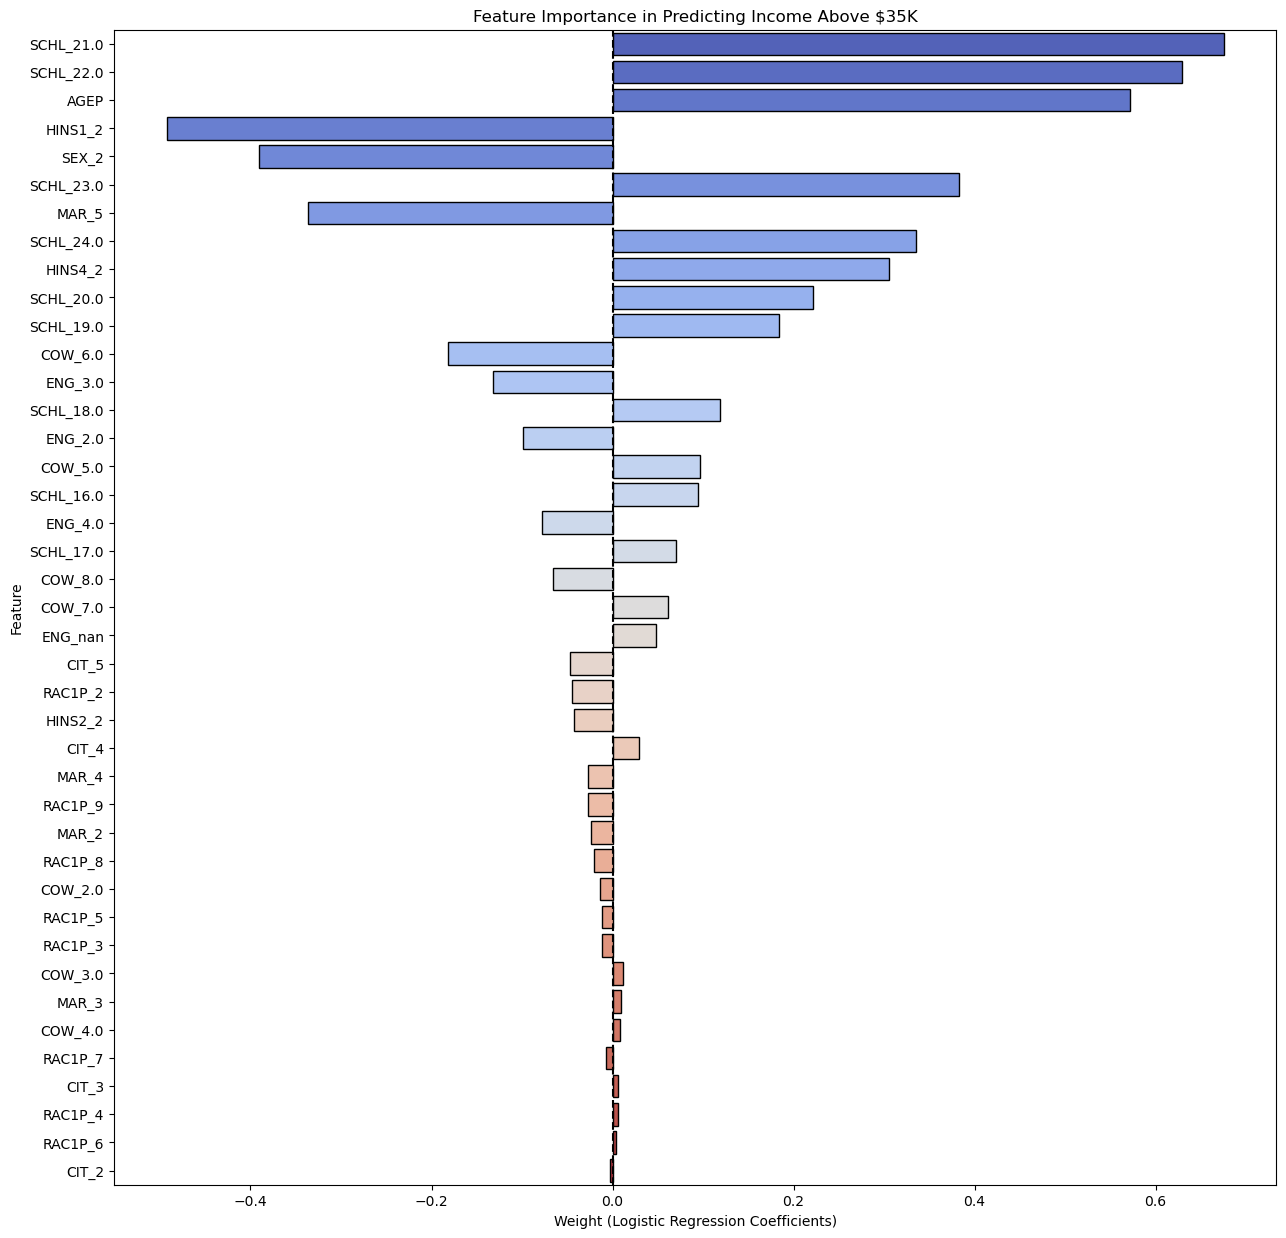

In [ ]:

# Create bar plot
plt.figure(figsize=(15, 15))
sns.barplot(x=weights_df["Weight"], y=weights_df["Feature"], palette="coolwarm", edgecolor="black")

# Labels and Title
plt.axvline(x=0, color='black', linestyle='dashed')
plt.xlabel("Weight (Logistic Regression Coefficients)")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Income Above $35K")

# Show plot
plt.show()

### question 4
4) Find a negative or a positive instance, and discuss how you can use the weights discussion to create a counterfactual. (E.g., "By increasing/decreasing feature ... to ..., the person is classified as ...").

In [12]:


# Get model predictions on test set
y_pred = logistic_model.predict(X_test)

# Find a negative instance (classified as ≤ $35K)
negative_indices = np.where(y_pred == 0)[0]  # Indices where model predicts ≤ $35K
negative_idx = negative_indices[0]  # Take the first one

x_negative = X_test.iloc[negative_idx].copy()  # Copy instance for modification

# Print current classification
print("Current Classification:", "Above $35K" if y_pred[negative_idx] == 1 else "Below $35K")
print("Original Features:\n", x_negative)


Current Classification: Below $35K
Original Features:
 AGEP         20
HINS1_2       0
HINS2_2       1
HINS4_2       1
CIT_2         0
CIT_3         0
CIT_4         0
CIT_5         0
COW_2.0       0
COW_3.0       0
COW_4.0       0
COW_5.0       0
COW_6.0       0
COW_7.0       0
COW_8.0       0
SCHL_16.0     0
SCHL_17.0     0
SCHL_18.0     0
SCHL_19.0     1
SCHL_20.0     0
SCHL_21.0     0
SCHL_22.0     0
SCHL_23.0     0
SCHL_24.0     0
MAR_2         0
MAR_3         0
MAR_4         0
MAR_5         1
SEX_2         1
RAC1P_2       0
RAC1P_3       0
RAC1P_4       0
RAC1P_5       0
RAC1P_6       1
RAC1P_7       0
RAC1P_8       0
RAC1P_9       0
ENG_2.0       0
ENG_3.0       0
ENG_4.0       0
ENG_nan       1
Name: 221451, dtype: int64


In [ ]:

# Step 3: Modify a feature with high impact (e.g., increase education level)
x_negative["SCHL_19.0"] = 0  # Change education level to Bachelor's degree
x_negative["SCHL_24.0"] = 1  # Remove lower education level
x_negative["SCHL_23.0"] = 0
x_negative["AGEP"] = 20
# if we give them a pdh but age 20, they keep being above
# Step 4: Predict again with modified features (Counterfactual)
new_pred = logistic_model.predict([x_negative])[0]
print("Counterfactual Classification:", "Above $35K" if new_pred == 1 else "Below $35K")


Counterfactual Classification: Above $35K


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


if level is 21 then it is below the 35k, if 22 then it is above 35k

# Task 2 (Decision tree)

1. Train a decision tree classifier on the training dataset. (You can work on the original dataset or on the one-hot encoded one.) The following parameter choices worked well in our setup: `(DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_features="auto", max_depth = 15, criterion = "gini", random_state = 0))` Report on its accuracy. Visualize the tree using `plot_tree` from `sklearn`. Which parameters can you change the adapt the size of the tree? Try to find parameters that make the tree easier to understand.
2. For two training examples, explain their classification given the decision tree.
3. Compute feature importance as shown in the lecture. Which features are most important?
4. Provide a counterfactual, as in Task 2.


### question 1
1. Train a decision tree classifier on the training dataset. (You can work on the original dataset or on the one-hot encoded one.) The following parameter choices worked well in our setup: `(DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_features="auto", max_depth = 15, criterion = "gini", random_state = 0))` Report on its accuracy. Visualize the tree using `plot_tree` from `sklearn`. Which parameters can you change the adapt the size of the tree? Try to find parameters that make the tree easier to understand.

In [68]:
tree_model = DecisionTreeClassifier(min_samples_split = 0.01, min_samples_leaf= 0.01, max_features=None, max_depth = 10, criterion = "gini", random_state = 0)
tree_model.fit(X_train, y_train)

tree_y_pred = tree_model.predict(X_test)

In [69]:
tree_accuracy = accuracy_score(y_test, tree_y_pred)
tree_accuracy

0.7615895897018818

filled: colors the nodes based on the predicted classes, making it easier to identiify which classes are predicted when
feature names give the names of the feature used to decide at that split 


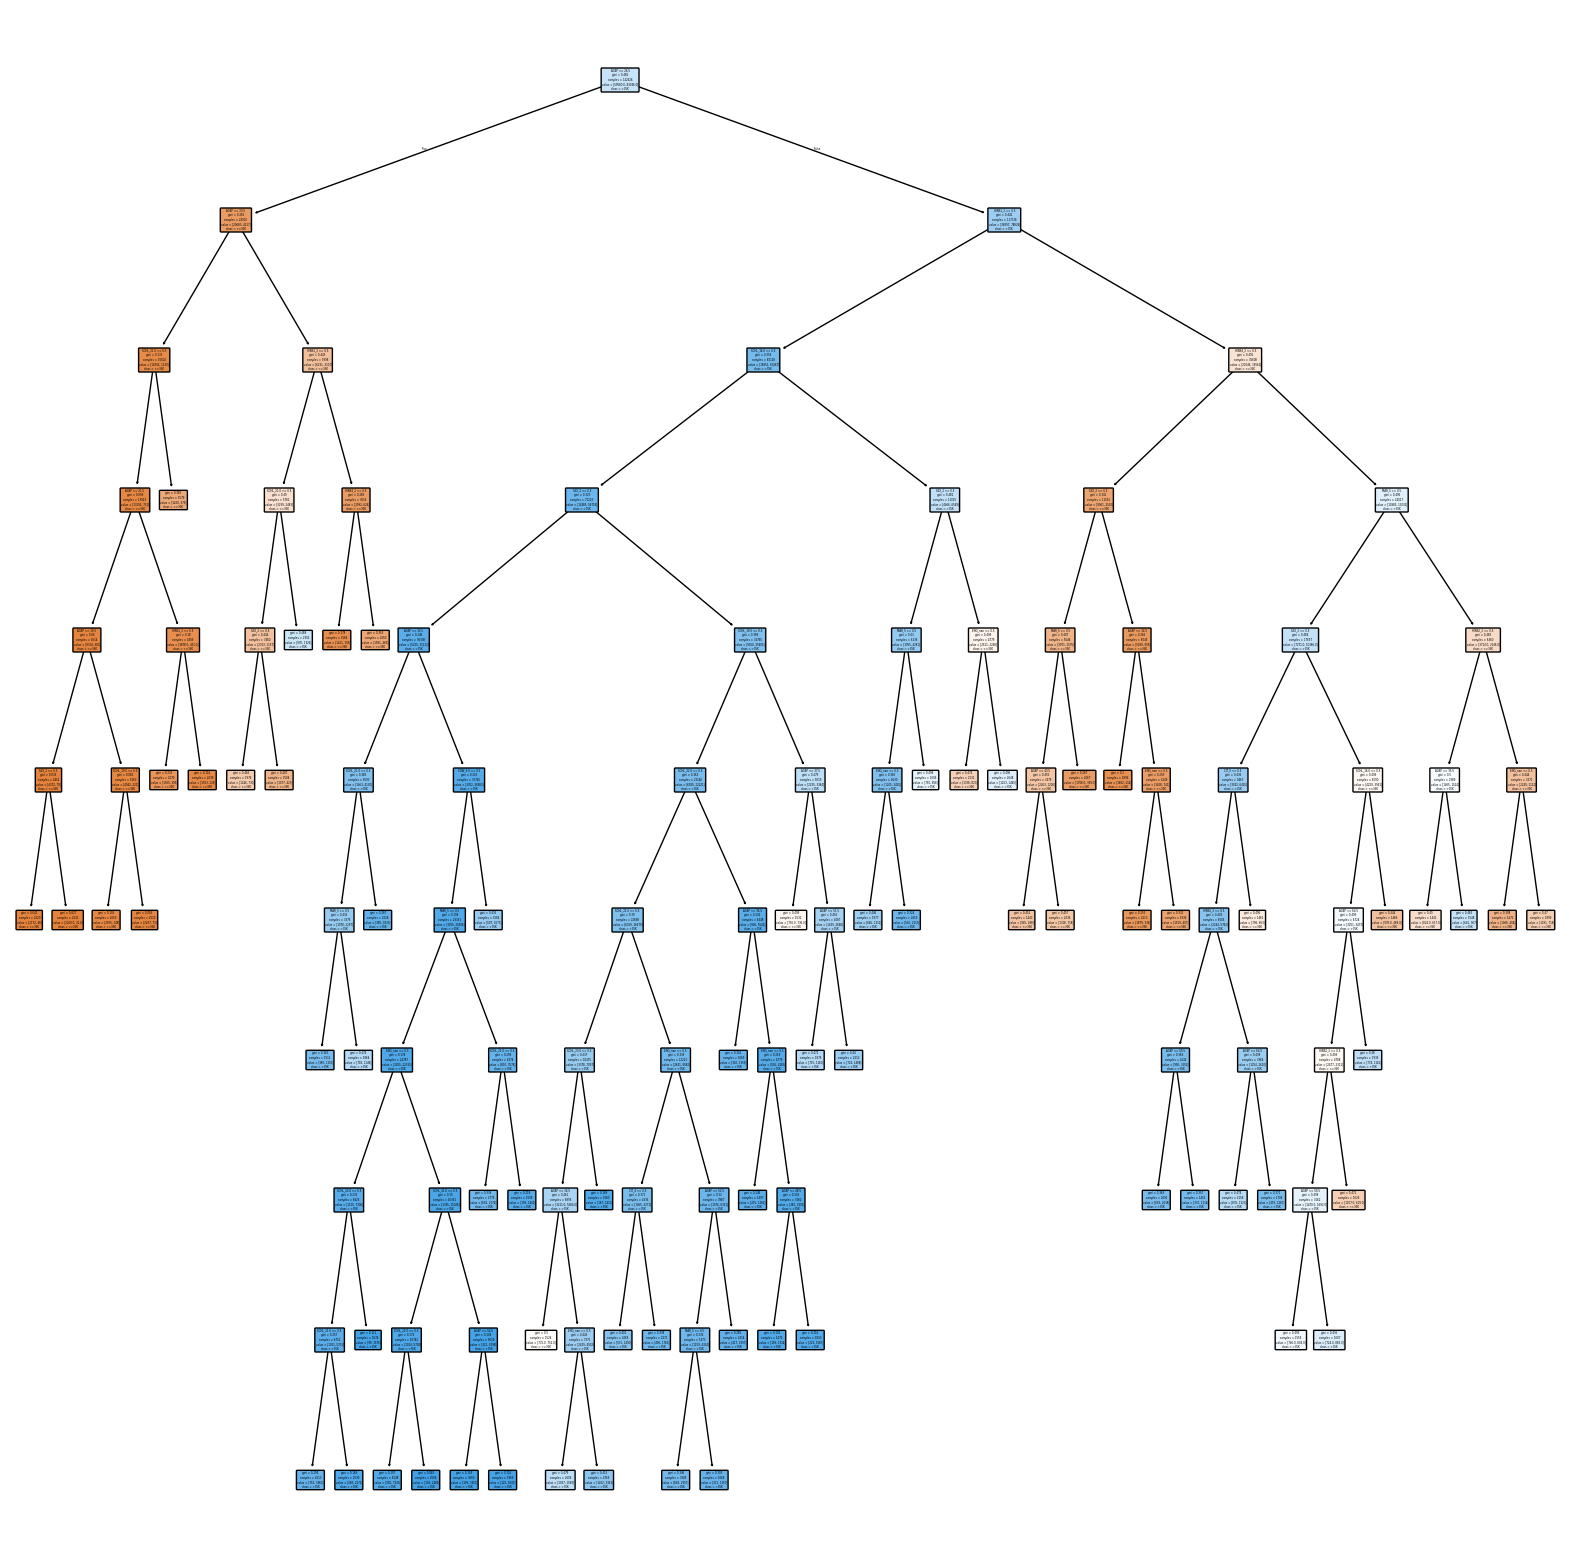

In [70]:
plt.figure(figsize=(20,20))
plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=['<=35K', '>35K'], rounded=True)
plt.show()

I changed max depth and max_features

### question 2
2. For two training examples, explain their classification given the decision tree.

In [73]:
# 1. Pick two training examples (indices of examples)
example_1_idx = 4  # First training example
example_2_idx = 99  # Second training example
# Retrieve the feature values for these examples
example_1 = X_train.iloc[example_1_idx].values.reshape(1, -1)
example_2 = X_train.iloc[example_2_idx].values.reshape(1, -1)

# 2. Get the predicted classes for these examples
pred_1 = tree_model.predict(example_1)[0]
pred_2 = tree_model.predict(example_2)[0]
print(f"Prediction for Example 1: {pred_1}")
print(f"Prediction for Example 2: {pred_2}")

# 3. Trace the decision path for each example
# Get the decision path for both examples
decision_path_1 = tree_model.decision_path(example_1)
decision_path_2 = tree_model.decision_path(example_2)
# Print decision paths (non-zero means the sample passes through that node)
print(f"Decision Path for Example 1: {decision_path_1}")
print(f"Decision Path for Example 2: {decision_path_2}")

Prediction for Example 1: True
Prediction for Example 2: True
Decision Path for Example 1:   (0, 0)	1
  (0, 24)	1
  (0, 25)	1
  (0, 26)	1
  (0, 52)	1
  (0, 53)	1
  (0, 71)	1
  (0, 73)	1
  (0, 75)	1
  (0, 76)	1
Decision Path for Example 2:   (0, 0)	1
  (0, 24)	1
  (0, 25)	1
  (0, 83)	1
  (0, 84)	1
  (0, 85)	1
  (0, 87)	1


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [75]:
# 4. You can also print the features involved at each split:
# Extract decision rules at each step of the tree
# (In this case, you'd need to map the node indices to the decision rules)
# For that, we will access the feature names and thresholds:

# To get the feature and threshold at each split:
features = X_train.columns
thresholds = tree_model.tree_.threshold
feature_indices = tree_model.tree_.feature

# Function to explain the path
def explain_path(decision_path, features, thresholds, feature_indices):
    path_explanation = []
    for node in decision_path.indices:
        if node == tree_model.tree_.n_node_samples.size - 1:  # Leaf node
            path_explanation.append("Leaf Node")
        else:
            feature_name = features[feature_indices[node]]
            threshold = thresholds[node]
            path_explanation.append(f"Feature: {feature_name} <= {threshold:.2f}")
    return path_explanation


In [76]:

# Explain paths for both examples
print("\nExplanation for Example 1 path:")
print(explain_path(decision_path_1, features, thresholds, feature_indices))

print("\nExplanation for Example 2 path:")
print(explain_path(decision_path_2, features, thresholds, feature_indices))


Explanation for Example 1 path:
['Feature: AGEP <= 26.50', 'Feature: HINS1_2 <= 0.50', 'Feature: SCHL_16.0 <= 0.50', 'Feature: SEX_2 <= 0.50', 'Feature: SCHL_19.0 <= 0.50', 'Feature: SCHL_22.0 <= 0.50', 'Feature: AGEP <= 35.50', 'Feature: ENG_nan <= 0.50', 'Feature: AGEP <= 48.50', 'Feature: ENG_4.0 <= -2.00']

Explanation for Example 2 path:
['Feature: AGEP <= 26.50', 'Feature: HINS1_2 <= 0.50', 'Feature: SCHL_16.0 <= 0.50', 'Feature: SEX_2 <= 0.50', 'Feature: MAR_5 <= 0.50', 'Feature: ENG_nan <= 0.50', 'Feature: ENG_4.0 <= -2.00']


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


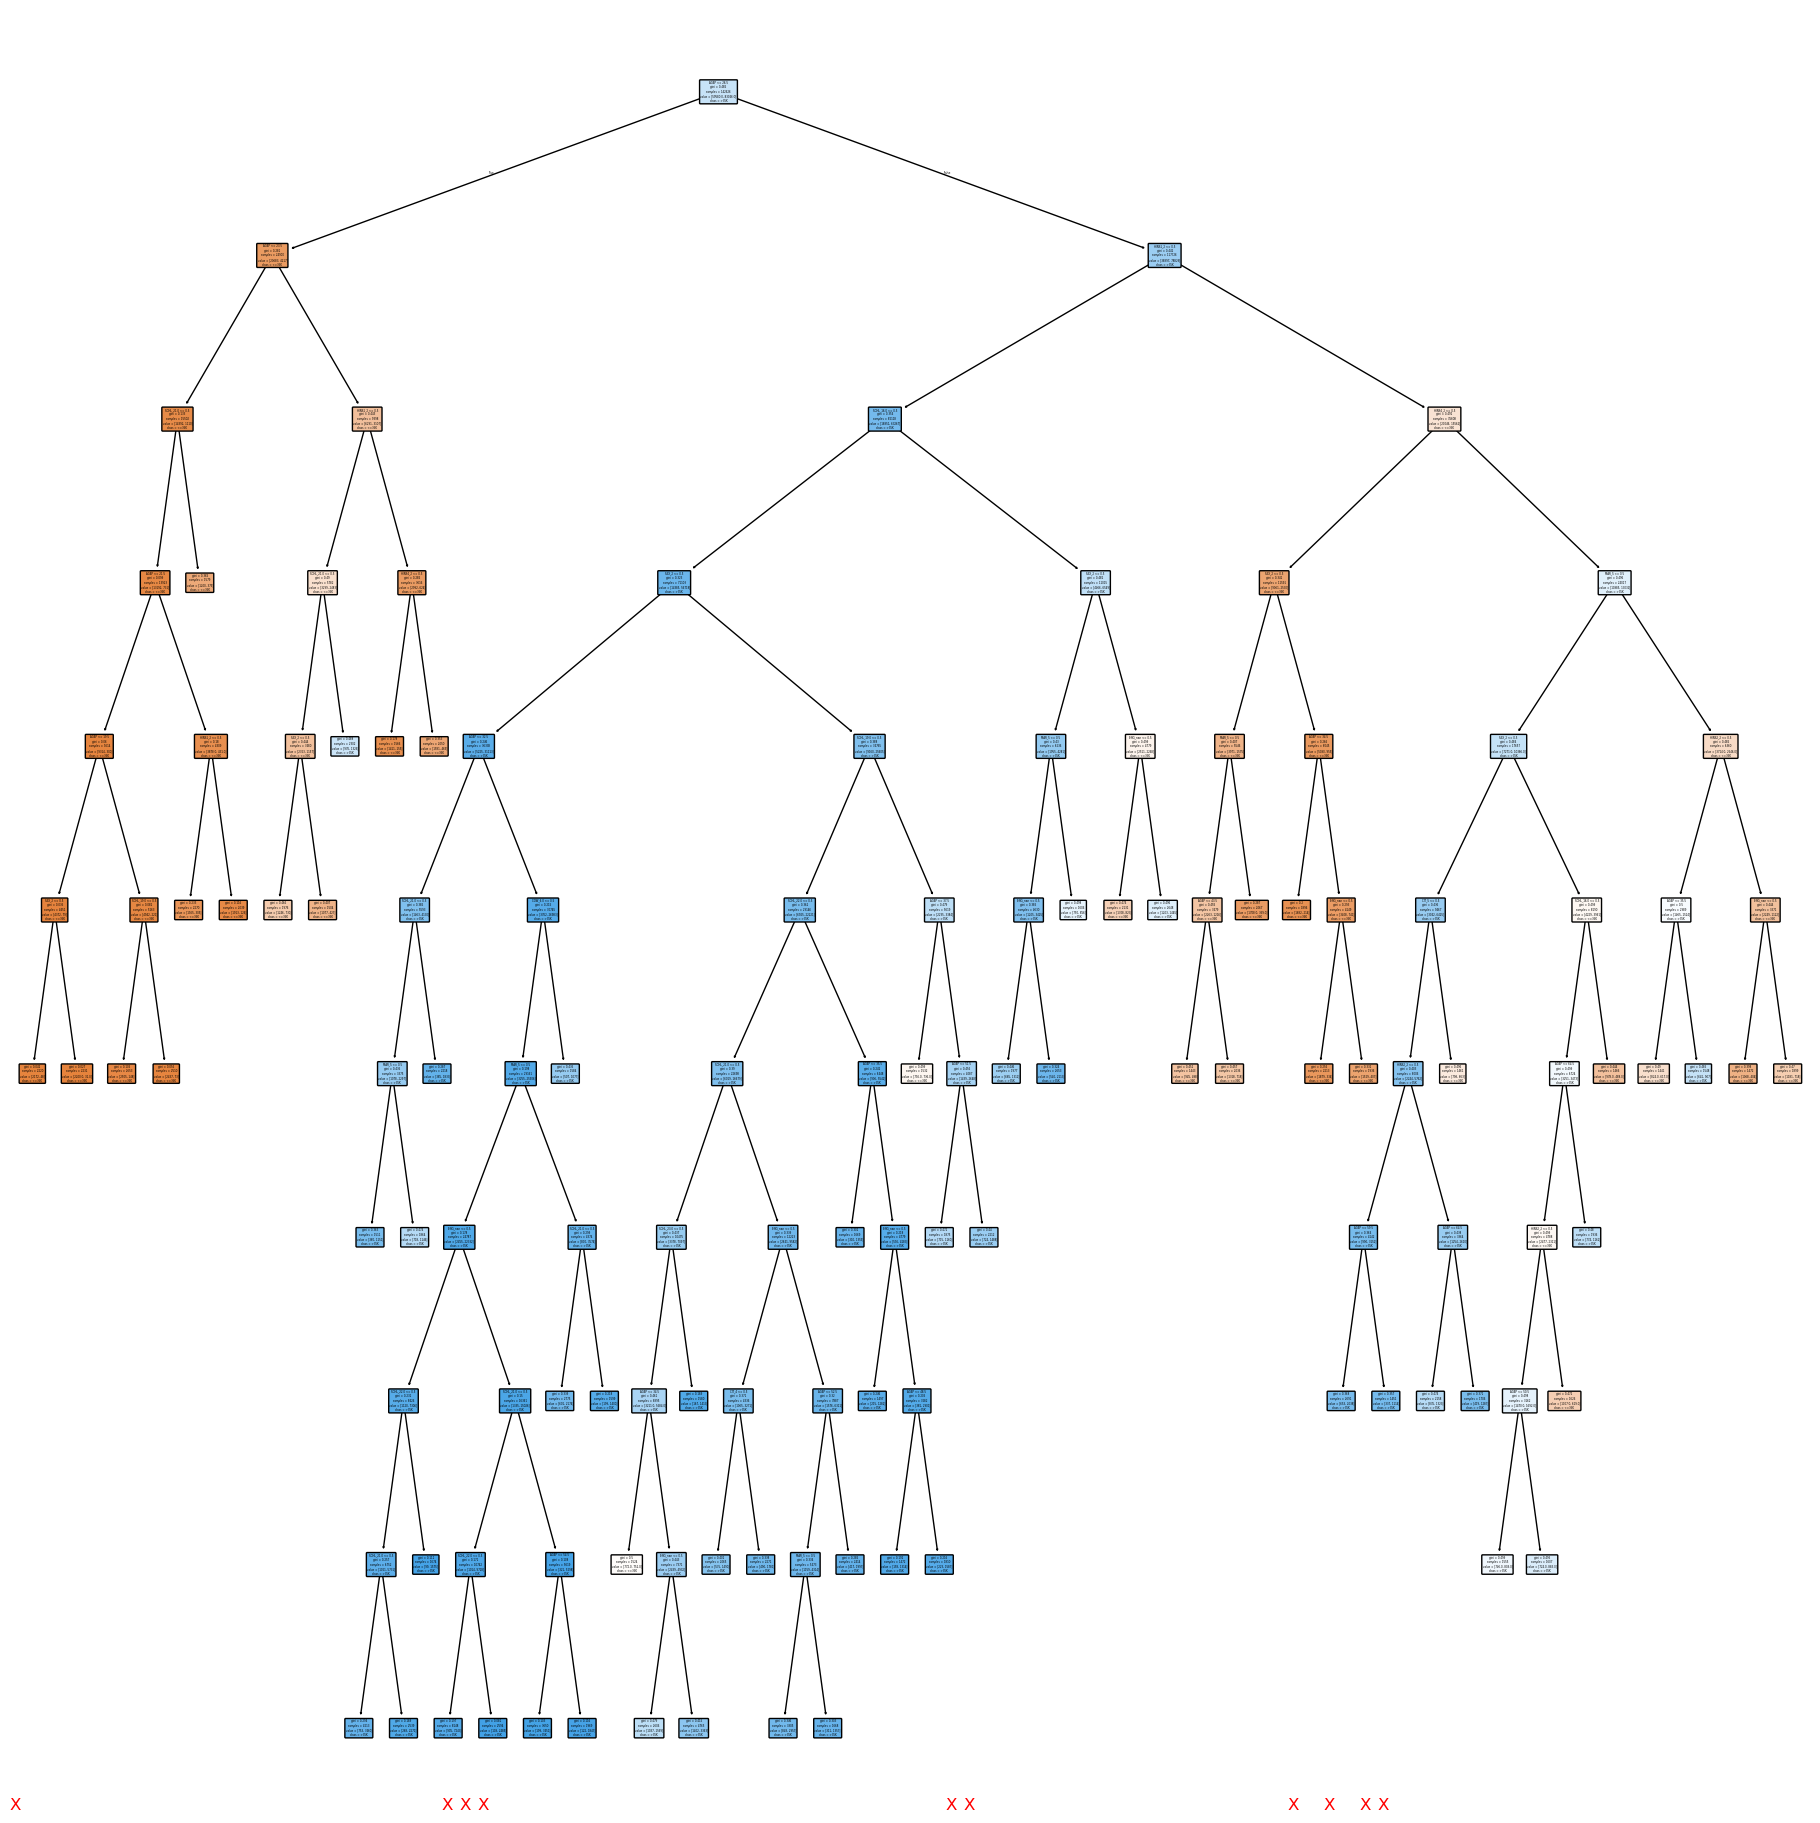

In [77]:
decision_path_1 = tree_model.decision_path(example_1)
# Plot the full decision tree
plt.figure(figsize=(20, 20))
plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=['<=35K', '>35K'], rounded=True)

# Get the decision nodes for the given instance (example_1)
nodes_in_path = decision_path_1.indices

# Iterate over the nodes and highlight them
for node in nodes_in_path:
    # Adjust position to mark the nodes correctly
    plt.text(x=node * 0.01, y=0, s='X', color='red', fontsize=12)  # Adjust x scaling factor as needed

# Adjust layout to reduce white space
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Show the plot
plt.show()


### question 3 feature importance
3. Compute feature importance as shown in the lecture. Which features are most important?

      Feature  Importance
0        AGEP    0.492666
1     HINS1_2    0.248039
3     HINS4_2    0.071294
28      SEX_2    0.050685
15  SCHL_16.0    0.036962
27      MAR_5    0.023444
20  SCHL_21.0    0.020996
18  SCHL_19.0    0.010366
40    ENG_nan    0.008682
21  SCHL_22.0    0.008412
2     HINS2_2    0.007652
22  SCHL_23.0    0.007445
7       CIT_5    0.007438
12    COW_6.0    0.005558
6       CIT_4    0.000362
13    COW_7.0    0.000000
9     COW_3.0    0.000000
39    ENG_4.0    0.000000
38    ENG_3.0    0.000000
37    ENG_2.0    0.000000
36    RAC1P_9    0.000000
35    RAC1P_8    0.000000
34    RAC1P_7    0.000000
33    RAC1P_6    0.000000
32    RAC1P_5    0.000000
31    RAC1P_4    0.000000
30    RAC1P_3    0.000000
29    RAC1P_2    0.000000
4       CIT_2    0.000000
14    COW_8.0    0.000000
26      MAR_4    0.000000
25      MAR_3    0.000000
8     COW_2.0    0.000000
23  SCHL_24.0    0.000000
10    COW_4.0    0.000000
11    COW_5.0    0.000000
5       CIT_3    0.000000
19  SCHL_20.

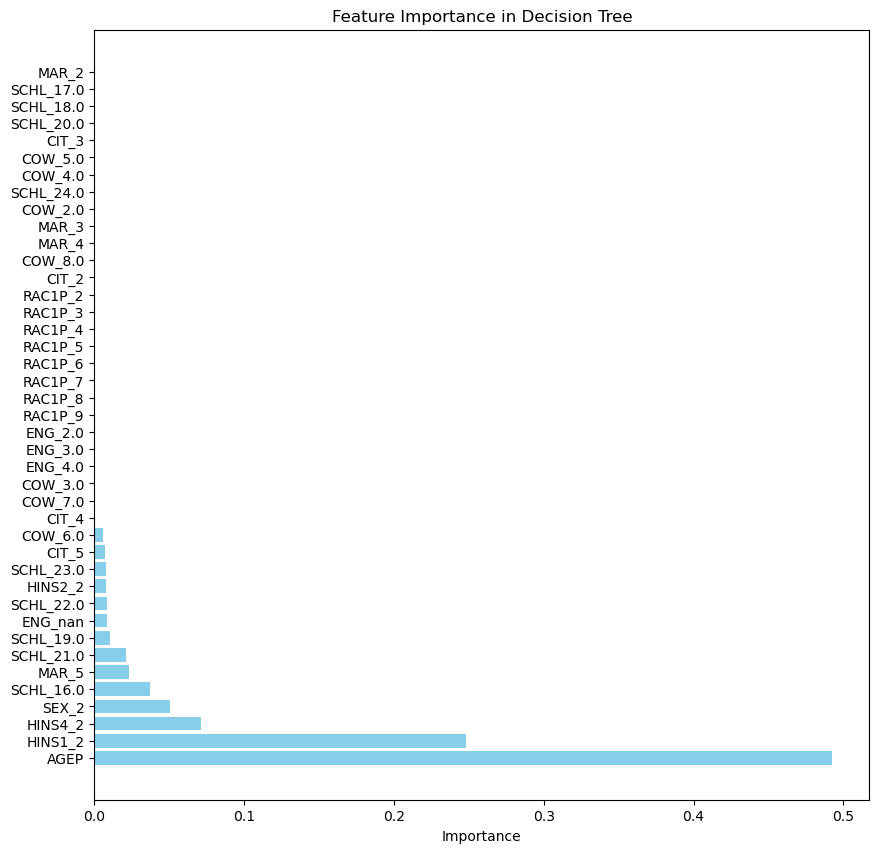

In [78]:
# Get feature importances
feature_importances = tree_model.feature_importances_

# Create a DataFrame to display feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print(feature_importance_df)

# Optional: Visualize the feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance in Decision Tree')
plt.show()

for fun, feature permutation

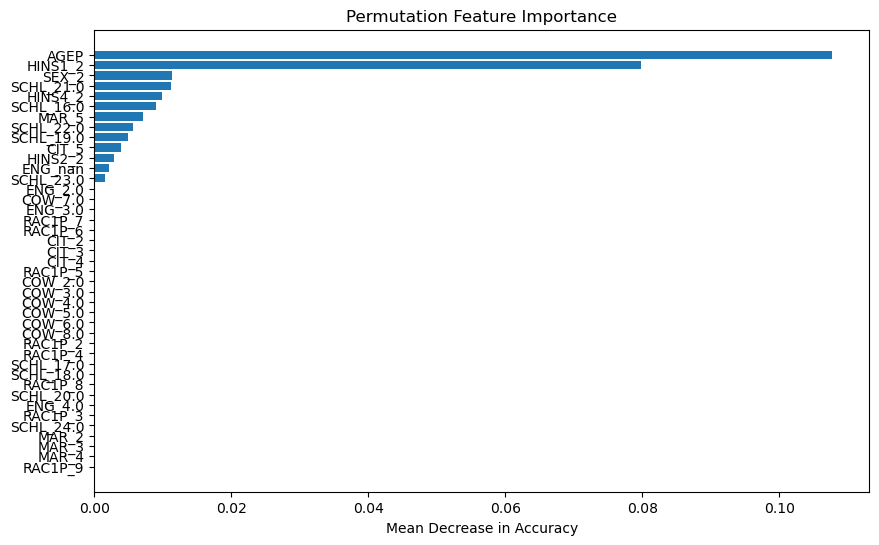

In [79]:
perm_importance = permutation_importance(tree_model, X_test, y_test, n_repeats=20, random_state=0)

# Extract feature importances and their corresponding feature names
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1]  # Sort in descending order
feature_names = X_test.columns  # Get feature names

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Mean Decrease in Accuracy")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

### question 4 counterfactual example

4. Provide a counterfactual, as in Task 2.

In [81]:
pred_1 = tree_model.predict(example_1)[0]
print(pred_1)

True


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [82]:
# Get the decision path for a specific instance (example_1)
decision_path_1 = tree_model.decision_path(example_1)

# Get the indices of the nodes that were traversed
nodes_in_path = decision_path_1.indices
print("Nodes traversed:", nodes_in_path)


Nodes traversed: [ 0 24 25 26 52 53 71 73 75 76]


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [83]:
# Get the tree's feature indices and thresholds
tree_feature_indices = tree_model.tree_.feature
tree_thresholds = tree_model.tree_.threshold

# Check the condition at each node
for node in nodes_in_path:
    feature_index = tree_feature_indices[node]
    threshold = tree_thresholds[node]
    print(f"Node {node} - Feature: {X_train.columns[feature_index]}, Threshold: {threshold}")


Node 0 - Feature: AGEP, Threshold: 26.5
Node 24 - Feature: HINS1_2, Threshold: 0.5
Node 25 - Feature: SCHL_16.0, Threshold: 0.5
Node 26 - Feature: SEX_2, Threshold: 0.5
Node 52 - Feature: SCHL_19.0, Threshold: 0.5
Node 53 - Feature: SCHL_22.0, Threshold: 0.5
Node 71 - Feature: AGEP, Threshold: 35.5
Node 73 - Feature: ENG_nan, Threshold: 0.5
Node 75 - Feature: AGEP, Threshold: 48.5
Node 76 - Feature: ENG_4.0, Threshold: -2.0


In [111]:
# Assume example_1 is the original instance to modify
x_cf = example_1.copy()
x_cf

array([[45,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1]])

In [112]:
X_train.columns.get_loc("SCHL_24.0")

23

In [117]:

# Modify the features to change classification

# Example of modifying feature values based on the threshold
#x_cf[0,40] = 0  # Changing SCHL_21.0 to 1 to ensure the split goes in the desired direction
x_cf[0,23] = 1     # Changing CIT_4 to 1
x_cf[0,0] = 20
# x_cf['CIT_5'] = 1      # Similarly change other features if necessary
x_cf

array([[20,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  1,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  1]])

In [118]:
x_cf_mod = x_cf.reshape(1,-1)


In [119]:

# Check the new classification after modification
new_prediction = tree_model.predict(x_cf_mod)
print(f"New prediction after modification: {new_prediction}")



New prediction after modification: [False]


/Users/alteafogh/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


only changing HINS4_2 change prediction


# Task 3 (Comparison)

Now you have both an interpretable logistic regression model and an interpretable decision tree model. Reflect on the explanations you can obtain from these two models: Do explanations from one model translate to the other? Do the counterfactuals from one work in the other model?  

having tried to change the different values for different examples from the dataset, we have observed that depending on the importance of features, the predictions change. but the two models have different important features, so you can't compare the two models one on one. 
there are some few features that have similar importance in the two models, but they are not completely the same. we can see that the level of edication has a positive impact on the prediction, and sometimes insurance. and age has also an influence. 